<a href="https://colab.research.google.com/github/nelsongs/mvp_4/blob/main/ML_Cardiovascular.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Engenharia de Sistemas de Software Inteligentes - Aluno: Nelson Gomes da Silveira
## MVP-4: ML_DoençaCardiovascular - Modelo de Classificação

In [1]:
# configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import pandas as pd # processamento dos dados, I/O do arquivo CSV etc
import numpy as np # algebra linear
import matplotlib.pyplot as plt # biblioteca para plotagem da acurácia dos modelos
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

## Carga do Dataset

In [30]:
"""
  Dataset relativo a doença cardiovascular
  Consiste de 70000 registros de dados de pacientes, 11 características coletadas + o alvo se sofre de doença cardiovascular ou não
  Há 3 tipos de características das entrada coletadas:
  - Objetiva: informação factual
  - Exame: resultado de exames médicos
  - Subjetiva: informação fornecida pelo paciente
  As 11 características que formam os dadso coletados no dataset são os seguintes:
  - Idade | Objetiva | age | int (dias)
  - Altura | Objetiva | height | int (cm)
  - Peso | Objetiva | weight | float (kg)
  - Sexo | Objetiva | gender | código da categoria ( 1 - masculino; 2 - feminino )
  - Pressão sanguínea Sistólica | Exame | ap_hi | int
  - Pressão sanguínea Diastólica | Exame | ap_lo | int
  - Colesterol | Exame | 1: normal, 2: acima do normal; 3: bem acima do normal
  - Glicose | Exame | gluc | 1: normal, 2: acima do normal, 3: bem acima do normal
  - Fumante | Subjetiva | smoke | binário (0: não, 1: sim)
  - Ingestão de alcool | Subjetiva | alco | binário (0: não, 1: sim)
  - Atividade física | Subjetiva | active | binário (0: não praticante, 1: praticante)

  Finalmente o alvo da classificação dos dados:
  - Presença ou ausência de doença cardiovascular | Variável Alvo| cardio | binário (0: não, 1: sim)
"""
# URL de importação do dataset
url = "https://raw.githubusercontent.com/nelsongs/mvp_4/main/cardio_train.csv"

# Lê o arquivo
dataset = pd.read_csv(url, delimiter=';')

# como a idade é fornecida em número de dias, precisamos convertê-la para anos
dataset['age'] = dataset['age'] // 365

# Exibe as primeiras linhas do dataset
dataset.head()


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,4,47,1,156,56.0,100,60,1,1,0,0,0,0


## Separação em conjunto de treino e conjunto de teste com holdout

In [56]:
test_size = 0.20 # tamanho do conjunto de teste
seed = 7 # semente aleatória

# Separação em conjuntos de treino e teste
array = dataset.values
X = array[:,0:11]
y = array[:,11]
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=test_size, shuffle=True, random_state=seed, stratify=y) # holdout com estratificação

# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # validação cruzada com estratificação


## Modelagem e Inferência

### Criação do modelo SVC e predições

KNN: 0.770536 (0.002372)
CART: 0.673589 (0.007813)
NB: 0.803179 (0.000471)
SVM: 0.803732 (0.000054)


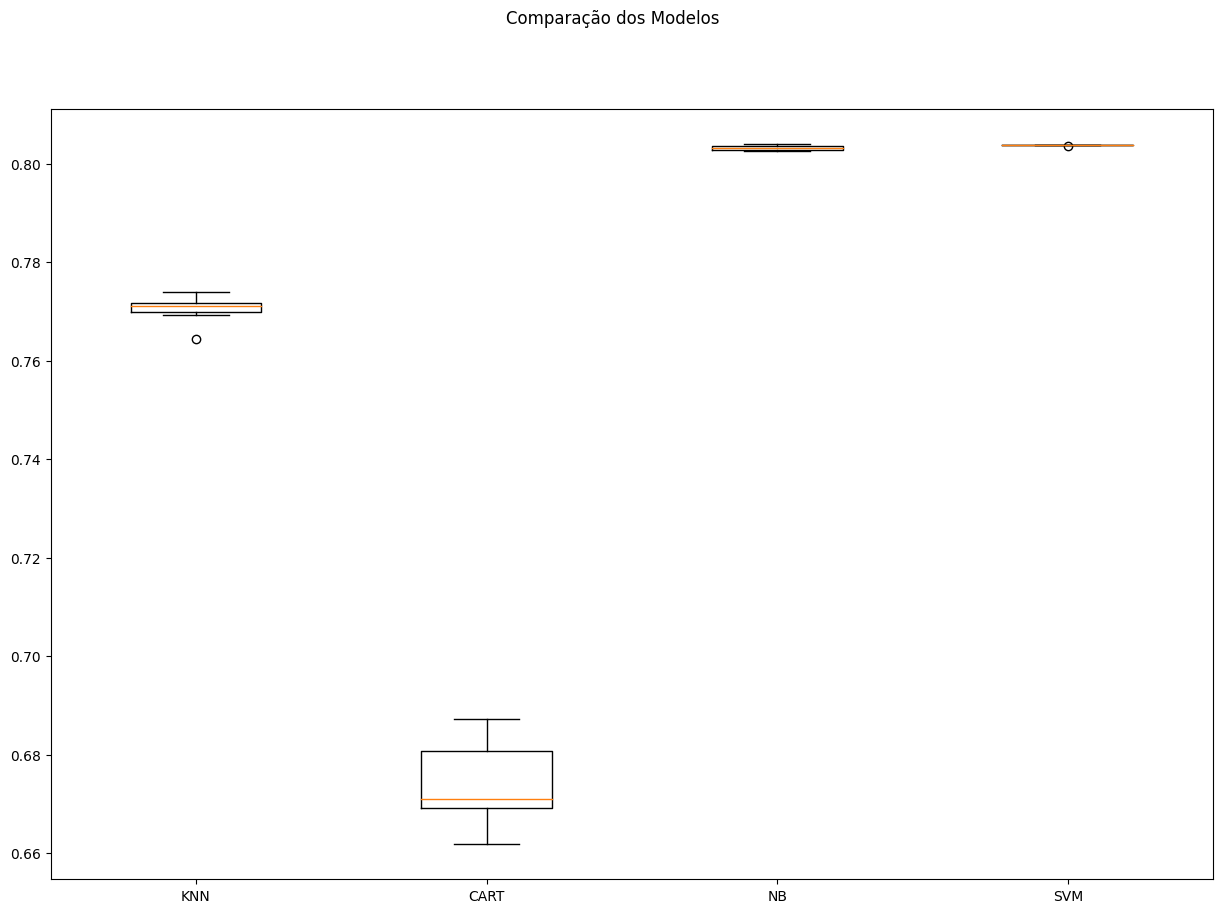

In [57]:
np.random.seed(7) # definindo uma semente global

# Lista que armazenará os modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# Listas para armazenar os resultados
results = []
names = []

# Avaliação dos modelos
for name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### Criação e avaliação de modelos: dados padronizados e normalizados

KNN-orig: 0.771 (0.002)
CART-orig: 0.674 (0.008)
NB-orig: 0.803 (0.000)
SVM-orig: 0.804 (0.000)
KNN-padr: 0.769 (0.003)
CART-padr: 0.674 (0.006)
NB-padr: 0.803 (0.001)
SVM-padr: 0.804 (0.000)
KNN-norm: 0.769 (0.003)
CART-norm: 0.673 (0.006)
NB-norm: 0.803 (0.001)
SVM-norm: 0.804 (0.000)


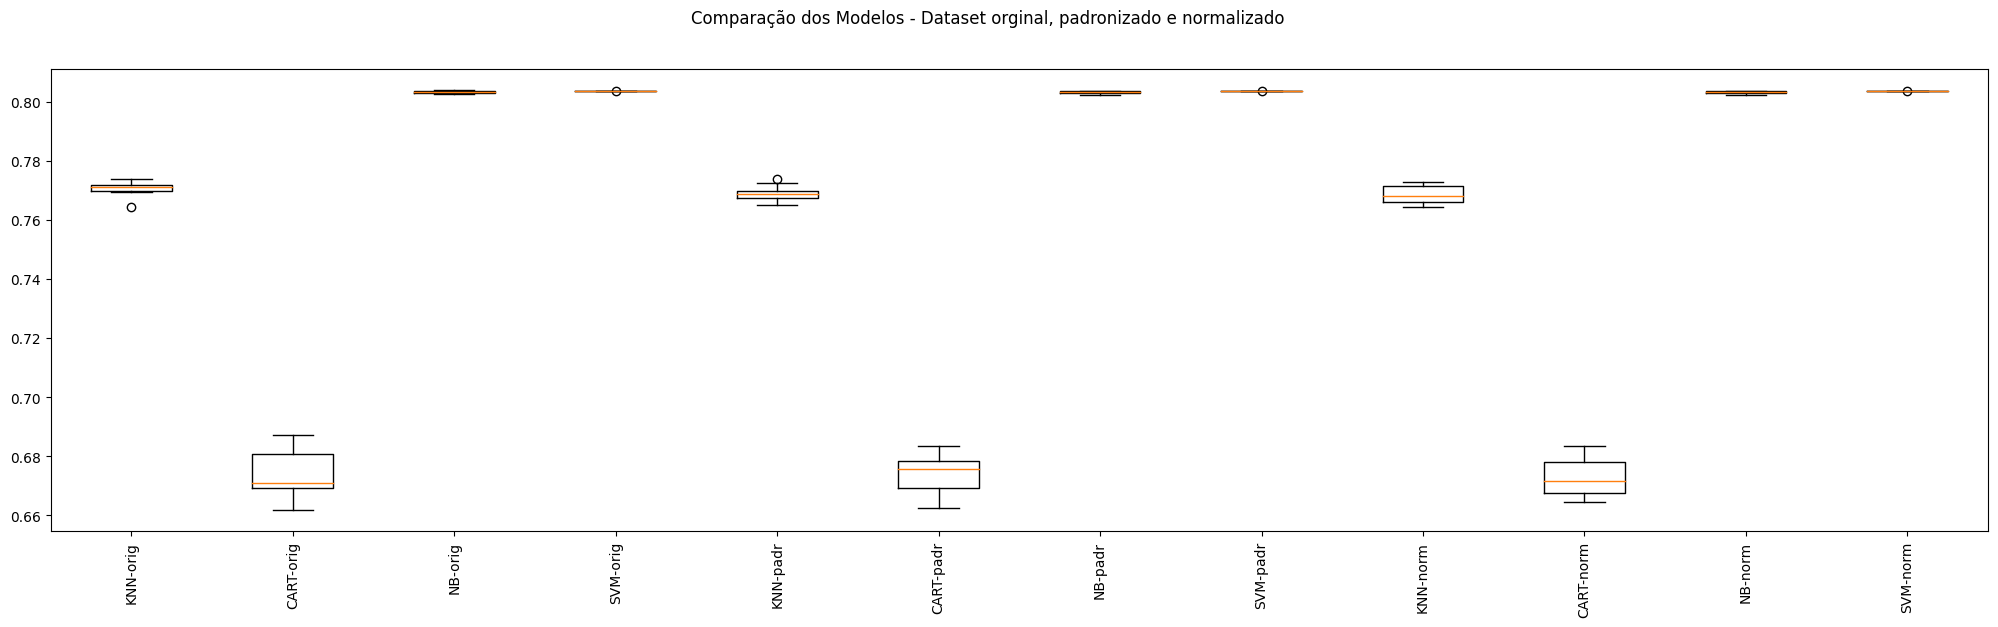

In [58]:
np.random.seed(7) # definindo uma semente global para este bloco

# Listas para armazenar os armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []


# Criando os elementos do pipeline

# Algoritmos que serão utilizados
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())


# Montando os pipelines

# Dataset original
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('SVM-orig', Pipeline([svm])))

# Dataset Padronizado
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))

# Dataset Normalizado
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))

# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) # formatando para 3 casas decimais
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

### Otimização dos hiperparâmetros

In [59]:
# Tuning do KNN

np.random.seed(7) # definindo uma semente global para este bloco

pipelines = []

# Definindo os componentes do pipeline
knn = ('KNN', KNeighborsClassifier())
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

pipelines.append(('knn-orig', Pipeline(steps=[knn])))
pipelines.append(('knn-padr', Pipeline(steps=[standard_scaler, knn])))
pipelines.append(('knn-norm', Pipeline(steps=[min_max_scaler, knn])))

param_grid = {
    'KNN__n_neighbors': [1,3,5,7,9,11,13,15,17,19,21],
    'KNN__metric': ["euclidean", "manhattan", "minkowski"],
}

# Prepara e executa o GridSearchCV
for name, model in pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_train, y_train)
    # imprime a melhor configuração
    print("Sem tratamento de missings: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))

Sem tratamento de missings: knn-orig - Melhor: 0.803375 usando {'KNN__metric': 'euclidean', 'KNN__n_neighbors': 21}
Sem tratamento de missings: knn-padr - Melhor: 0.803000 usando {'KNN__metric': 'euclidean', 'KNN__n_neighbors': 21}
Sem tratamento de missings: knn-norm - Melhor: 0.803286 usando {'KNN__metric': 'euclidean', 'KNN__n_neighbors': 21}


## Finalização do Modelo

In [52]:
# Avaliação do modelo com o conjunto de testes

# Preparação do modelo
scaler = StandardScaler().fit(X_train) # ajuste do scaler com o conjunto de treino
rescaledX = scaler.transform(X_train) # aplicação da padronização no conjunto de treino
model = KNeighborsClassifier(metric='manhattan', n_neighbors=17)
model.fit(rescaledX, y_train)

# Estimativa da acurácia no conjunto de teste
rescaledTestX = scaler.transform(X_test) # aplicação da padronização no conjunto de teste
predictions = model.predict(rescaledTestX)
print(accuracy_score(y_test, predictions))

0.8017857142857143


In [53]:
# Preparação do modelo com TODO o dataset
scaler = StandardScaler().fit(X) # ajuste do scaler com TODO o dataset
rescaledX = scaler.transform(X) # aplicação da padronização com TODO o dataset
model.fit(rescaledX, y)

KNeighborsClassifier(metric='manhattan', n_neighbors=17)

## Simulando a aplicação do modelo em dados não vistos

In [54]:
# Novos dados - não sabemos a classe!
data = {'age': [15, 40, 45],
        'sex':  [1, 2, 2],
        'alt': [155, 157, 170],
        'pes': [74.2, 61.3, 64.5],
        'sist': [115, 135, 160],
        'diast': [85, 72, 92],
        'cole': [2, 1, 3],
        'gli': [3, 2, 1],
        'fum': [1, 1, 0],
        'ping': [0, 1, 0],
        'malha': [1, 0, 0],
        }

atributos = ['age', 'sex', 'alt', 'pes', 'sist', 'diast', 'cole', 'gli', 'fum', 'ping', 'malha']
entrada = pd.DataFrame(data, columns=atributos)

array_entrada = entrada.values
X_entrada = array_entrada[:,0:11].astype(float)

# Padronização nos dados de entrada usando o scaler utilizado em X
rescaledEntradaX = scaler.transform(X_entrada)
print(rescaledEntradaX)

[[-1.73156054e+00 -7.66111656e+00  3.22230026e+02 -1.09815451e+01
   2.83379348e+00 -2.84508765e-01 -5.02094868e-01  2.40079294e+00
  -3.95719942e-01 -3.10879125e-01  4.19490608e+00]
 [-1.73069403e+00 -7.51333459e+00  3.26424352e+02 -1.25527867e+01
   4.22310168e+00 -3.68918693e-01 -5.07400719e-01  9.30735420e-01
  -3.95719942e-01  3.21668430e+00 -2.38384360e-01]
 [-1.73052072e+00 -7.51333459e+00  3.53687474e+02 -1.21630213e+01
   5.95973694e+00 -2.39057265e-01 -4.96789017e-01 -5.39322104e-01
  -2.14315849e+00 -3.10879125e-01 -2.38384360e-01]]


In [55]:
# Predição de classes dos dados de entrada
saidas = model.predict(rescaledEntradaX)
print(saidas)

[1. 1. 1.]
